In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [2]:
df = pd.read_csv('data/clean_nonull.csv')

df = pd.concat([
    df.drop(columns=['VKORC1_SNP', 'CYP2C9 consensus']),
    pd.get_dummies(df['VKORC1_SNP'], prefix='VKORC1_SNP'),
    pd.get_dummies(df['CYP2C9 consensus'], prefix='CYP2C9')
], axis=1)

df['label'] = df['correct_dosage'].map({'low': 0, 'medium': 1, 'high': 2})

In [3]:
def clinical_baseline(x):
    x = np.squeeze(x)
    
    sqrt_weekly_dose = 4.0376 - 0.2546 * x[0] + 0.0118 * x[1] \
    + 0.0134 * x[2] - 0.6752 * x[3] \
    + 0.4060 * x[4] + 0.0443 * x[5] \
    + 1.2799 * x[6] - 0.5695 * x[7]
    
    
    cutoffs = np.array([0, np.sqrt(21), np.sqrt(49)])
    
    return np.where(cutoffs < sqrt_weekly_dose)[0].max()

In [21]:
np.random.seed(1)

S = 20


perfs = []
for s in tqdm(range(S)):
    order = np.random.choice(range(df.shape[0]), size=df.shape[0], replace=False)
    X = df.drop(columns=['correct_dosage', 'label']).iloc[order, :].values
    y = df['label'].values[order]
    
    delta = 3 / X.shape[0] ## set it equal to |A|/T, for lack of a better option; see slides for UCB1 (lecture 10, slide 49)
    R = 5
    v = R * np.sqrt(9 * X.shape[1] * np.log(X.shape[0] / delta))

    # randomly sample the first arm, and set the corresponding reward
    chosen_arms = [np.random.randint(3)]
    rewards = [0 if chosen_arms[0] == y[0] else -1]
                
    # add indicators for which of the previous arms was chosen
    add = np.zeros(3)
    add[chosen_arms[0]] = 1

    # concatenate these arm features to our feature vector
    b_0 = np.hstack([X[0], add]).reshape(X.shape[1] + 3, 1)
                
    sum_br =  b_0 * rewards[0]

    B = np.identity(X.shape[1] + 3) + b_0 @ b_0.T
    mu_hat = np.linalg.inv(B) @ sum_br

    for i in range(1, X.shape[0]):  # choose a patient
        mu_tilde = multivariate_normal(np.squeeze(mu_hat), (v ** 2) * np.linalg.inv(B)).rvs()
        
        x_t = X[i]
        
        vals = []
        bs = []
        for a in range(3):
            add = np.zeros(3)
            add[a] = 1
            b_cand = np.hstack([x_t, add]).reshape(X.shape[1] + 3, 1)
            bs.append(b_cand)
            vals.append(np.dot(np.squeeze(b_cand), mu_tilde))
        
        pred_a = int(np.argmax(vals))
        
        r_t = 0 if y[i] == pred_a else -1
        
        # update the parameters
        b_t = bs[pred_a]
        B += b_t @ b_t.T
        sum_br += b_t * r_t
        mu_hat = np.linalg.inv(B) @ sum_br

        chosen_arms.append(pred_a)
        rewards.append(r_t)
        
    perf = pd.DataFrame({
        "run": s,
        "predicted_arm": chosen_arms,
        "observed_reward": rewards,
        "true_arm": y,
        "clincal_baseline_predicted_arm": [clinical_baseline(x) for x in X]
    })

    perf['cumulative_accuracy'] = (
        perf['predicted_arm'] == perf['true_arm']
    ).cumsum() / (perf.index + 1)

    perf['cumulative_fixed_baseline_accuracy'] = (
        perf['true_arm'] == 1
    ).cumsum() / (perf.index + 1)
    
    perf['cumulative_clinical_baseline_accuracy'] = (
        perf['clincal_baseline_predicted_arm'] == perf['true_arm']
    ).cumsum() / (perf.index + 1)

    perf['cumulative_regret'] = -1 * perf['observed_reward'].cumsum()

    perf['cumulative_fixed_baseline_regret'] = -1 * np.where(
        perf['true_arm'] == 1,
        0,
        -1
    ).cumsum()
    
    perf['cumulative_clinical_baseline_regret'] = -1 * np.where(
        perf['clincal_baseline_predicted_arm'] == perf['true_arm'],
        0,
        -1
    ).cumsum()
    
    perfs.append(perf)

ts_performances = pd.concat(perfs)
ts_performances['t'] = ts_performances.index

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:26<00:00,  4.32s/it]


<AxesSubplot:xlabel='t'>

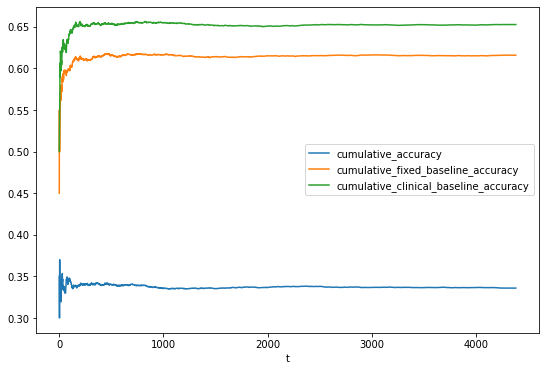

In [22]:
ts_grouped = ts_performances.groupby('t')[[
    'cumulative_accuracy', 'cumulative_fixed_baseline_accuracy', 'cumulative_clinical_baseline_accuracy',
    'cumulative_regret', 'cumulative_fixed_baseline_regret', 'cumulative_clinical_baseline_regret'
]].mean()    

ts_grouped[[
    'cumulative_accuracy',
    'cumulative_fixed_baseline_accuracy',
    'cumulative_clinical_baseline_accuracy'
]].plot(figsize=(9,6))

<AxesSubplot:xlabel='t'>

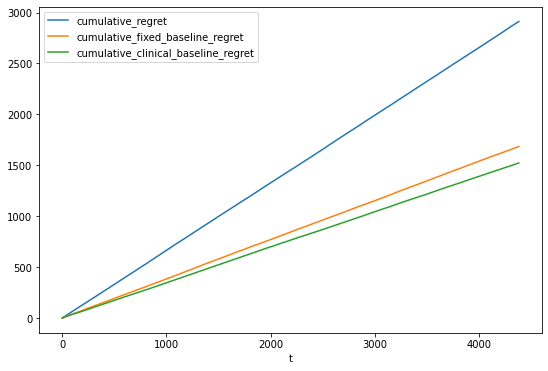

In [23]:
ts_grouped[[
    'cumulative_regret',
    'cumulative_fixed_baseline_regret',
    'cumulative_clinical_baseline_regret'
]].plot(figsize=(9,6))